# Use Case 5: Gene set enrichment analysis

## Step 1: Importing packages and setting up your notebook.

We start the notebook by importing the standard packages for data science. These are useful for playing data in dataframes and for plotting the results.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import gseapy as gp
from gseapy.plot import barplot, dotplot

Our cancer data and a variety of accessory functions are provided in the CPTAC package.

In [4]:
import CPTAC.Endometrial as en

Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


## Step 2: Getting data

We begin by retrieving the clinical and proteomics dataframes utilizing the <code>en.get_clinical()</code> and <code>en.get_proteomics()</code> functions.

In [5]:
clinical = en.get_clinical()
proteomics = en.get_proteomics()

## Step 3: Merging dataframes

For this example we will be separating the protein abudance based on the clinical column "Proteomics_Tumor_Normal." We first combine the clinical information into the proteomics dataframe utilizing the <code>en.compare_clinical()</code> function.

In [25]:
tumorProt = en.compare_clinical(proteomics, 'Proteomics_Tumor_Normal')

## Step 4: Organizing the data

We then separate the proteomics into two groups, based on whether the patient is categorized as "Tumor" or "Normal" (everything besides "Tumor").

In [26]:
#Retrieve boolean array of true values
tumor_bool = tumorProt['Proteomics_Tumor_Normal'] == "Tumor"
normal_bool = tumorProt['Proteomics_Tumor_Normal'] != "Tumor"
#Use boolean array to select for appropriate patients
tumor = tumorProt[tumor_bool]
normal = tumorProt[normal_bool]

## Step 5: Perform statistical tests

Next, we find which genes that are upregulated in each partition using Welch's t-test (a variation on the two sample t-test due to different variances between the two groups) to compare the "Tumor" individuals with the "Normal" individuals for each gene.

In [28]:
#Create array variables to hold the significant genes for each partition
tumor_genes = []
normal_genes = []
#Grab the genes of interest, ignoring the MSI column in the dataframe
genes = tumor.columns[1:]
#Correct alpha level for multiple testing by dividing the standard .05 by the number of genes to be analyzed
threshold = .05 / len(genes)
#Perform Welch's t-test(different variances) on each gene between the two groups
for gene in genes:
    tumor_gene_abundance = tumor[gene]
    normal_gene_abundance = normal[gene]
    pvalue = stats.ttest_ind(tumor_gene_abundance, normal_gene_abundance, equal_var = False, nan_policy='omit').pvalue
    #If the P-value is significant, determine which partition is more highly expressed
    if pvalue < threshold:
        if tumor_gene_abundance.mean() > normal_gene_abundance.mean():
            tumor_genes.append(gene)
        elif normal_gene_abundance.mean() > tumor_gene_abundance.mean():
            normal_genes.append(gene)
#Optional check of number of genes in each partition
print("Proteomics Tumor Genes:", len(tumor_genes))
print("Proteomics Normal Genes:", len(normal_genes))

Proteomics Tumor Genes: 2079
Proteomics Normal Genes: 2167


## Step 6: Gene set enrichment analysis

We then use the genes that are up-regulated in these partitions to perform a Gene Set Enrichment Analysis using the <code>gp.enrichr()</code> function (<code>gp</code> being the specified abbreviation for the imported gseapy package).

In [30]:
tumor_enr = gp.enrichr(gene_list = tumor_genes, description='Tumor partition', gene_sets='KEGG_2016', outdir='test/enrichr_kegg',cutoff=.5)
normal_enr = gp.enrichr(gene_list = normal_genes, description='Normal partition', gene_sets='KEGG_2016', outdir='test/enrichr_kegg',cutoff=.5)

We can view the data as a table by using the <code>obj.res2d</code> command (<code>obj</code> being the variable name specified in the previous step). The Gene Set Enrichment Analysis returns a list of pathways the genes provided are involved in, based on a significant adjusted P-value.

In [31]:
tumor_enr.res2d

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Z-score,Combined Score,Genes,Gene_set
0,Ribosome_Homo sapiens_hsa03010,77/137,4.299404e-40,1.229630e-37,5.627288e-21,1.609404e-18,-1.746138,158.278557,RPL4;RPL5;MRPS15;RPL30;RPL3;MRPS11;RPLP1;RPLP0...,KEGG_2016
1,Proteasome_Homo sapiens_hsa03050,31/44,3.620592e-21,5.177446e-19,5.908271e-11,8.448828e-09,-1.687623,79.432448,PSMD12;PSMD11;PSMD13;PSMA7;PSMB10;PSMD8;PSMB6;...,KEGG_2016
2,Metabolic pathways_Homo sapiens_hsa01100,203/1239,1.527237e-11,1.091974e-09,1.482701e-03,3.028946e-02,-1.937089,48.243162,GLDC;PANK1;ENO1;EPRS;IL4I1;C1GALT1C1;NSDHL;PNP...,KEGG_2016
3,Lysosome_Homo sapiens_hsa04142,41/123,4.815541e-12,4.590816e-10,1.447716e-06,1.380155e-04,-1.724371,44.935680,CD63;ASAH1;HEXB;CTSZ;HEXA;CLTC;CLTA;LIPA;CTSS;...,KEGG_2016
4,Protein processing in endoplasmic reticulum_Ho...,47/169,1.768396e-10,1.011522e-08,1.548660e-05,1.107292e-03,-1.718807,38.597146,VCP;HSP90AB1;PRKCSH;SAR1B;DERL1;RRBP1;RNF5;HER...,KEGG_2016
5,Peroxisome_Homo sapiens_hsa04146,28/83,8.342437e-09,3.976562e-07,5.586748e-05,3.195620e-03,-1.567626,29.160831,ABCD3;MVK;HSD17B4;HMGCL;PRDX5;SCP2;PRDX1;HACL1...,KEGG_2016
6,Amino sugar and nucleotide sugar metabolism_Ho...,19/48,1.138680e-07,4.652320e-06,1.679060e-04,7.873590e-03,-1.574624,25.175452,TSTA3;GPI;HEXB;GFPT1;HEXA;PMM2;UAP1;NPL;HK2;HK...,KEGG_2016
7,DNA replication_Homo sapiens_hsa03030,16/36,1.681913e-07,6.012839e-06,1.927102e-04,7.873590e-03,-1.539977,24.020821,RFC5;PRIM2;FEN1;PCNA;RFC4;LIG1;MCM7;PRIM1;POLA...,KEGG_2016
8,RNA transport_Homo sapiens_hsa03013,40/172,7.795102e-07,2.477110e-05,1.432559e-03,3.028946e-02,-1.673121,23.531778,EIF4A1;POP1;RPP30;GEMIN2;XPO5;SMN1;RPP14;EIF4E...,KEGG_2016
9,Aminoacyl-tRNA biosynthesis_Homo sapiens_hsa00970,21/66,1.781132e-06,4.245032e-05,8.645695e-04,2.747410e-02,-1.709081,22.625264,YARS;DARS;VARS;MARS2;DARS2;TARS;GATB;EPRS;QRSL...,KEGG_2016


In [32]:
normal_enr.res2d

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Z-score,Combined Score,Genes,Gene_set
0,Focal adhesion_Homo sapiens_hsa04510,73/202,1.212635e-21,2.199335e-19,6.094032e-14,1.621012e-11,-1.922008,92.566754,ITGB1;ITGB3;PTEN;ILK;LAMC1;MYLK3;MYLK;CRKL;AKT...,KEGG_2016
1,Complement and coagulation cascades_Homo sapie...,43/79,1.653635e-21,2.199335e-19,3.690586e-13,4.908480e-11,-1.791530,85.727045,CFD;CPB2;SERPINA1;CFH;C1S;SERPINC1;C1R;PROS1;C...,KEGG_2016
2,Endocytosis_Homo sapiens_hsa04144,73/259,6.915452e-15,6.131701e-13,9.988405e-10,8.856386e-08,-1.912425,62.354638,ZFYVE9;ARPC1A;WIPF3;CLTB;SNX12;AP2A1;ARRB1;WAS...,KEGG_2016
3,Pathways in cancer_Homo sapiens_hsa05200,94/397,1.368965e-13,7.282893e-12,8.221197e-09,4.373677e-07,-2.003006,59.328125,ITGB1;CDKN1B;PTEN;LAMC1;FGF1;FGF2;CRKL;IKBKB;F...,KEGG_2016
4,MAPK signaling pathway_Homo sapiens_hsa04010,70/255,1.037192e-13,6.897330e-12,5.680634e-09,3.777621e-07,-1.921409,57.444530,ATF2;HSPB1;ARRB1;FGF1;FGF2;CRKL;IKBKB;RPS6KA4;...,KEGG_2016
5,AGE-RAGE signaling pathway in diabetic complic...,38/101,1.436318e-12,6.367675e-11,3.227208e-08,1.430729e-06,-1.919166,52.333611,CDKN1B;FOXO1;MAPK9;AKT2;AKT3;PLCG2;AKT1;PLCE1;...,KEGG_2016
6,Proteoglycans in cancer_Homo sapiens_hsa05205,58/203,2.191562e-12,8.327934e-11,3.820251e-08,1.451695e-06,-1.858038,49.881643,ITGB1;ITGB3;HSPB2;FGF2;AKT2;AKT3;AKT1;TIMP3;PL...,KEGG_2016
7,Dopaminergic synapse_Homo sapiens_hsa04728,42/129,2.447563e-11,8.138148e-10,1.711129e-07,5.689505e-06,-1.707670,41.724086,ATF2;CAMK2D;MAOB;MAOA;ITPR1;GNAI1;GNAI2;ARNTL;...,KEGG_2016
8,cGMP-PKG signaling pathway_Homo sapiens_hsa04022,49/167,3.889964e-11,1.149700e-09,2.301175e-07,6.801251e-06,-1.734640,41.579388,ATF2;IRS1;IRS2;MYLK3;SLC8A1;MYLK;PPP3CA;RGS2;E...,KEGG_2016
9,Oxytocin signaling pathway_Homo sapiens_hsa04921,46/158,2.037486e-10,4.731608e-09,6.505278e-07,1.531543e-05,-1.709626,38.148817,CAMK2D;PRKAA1;ROCK1;ROCK2;NPR2;ITPR1;ADCY3;MYL...,KEGG_2016


## Step 7: Plot the p-values

We can better visualize these tables and the significant pathways detected through the gseapy imported <code>barplot()</code> function, which takes an enrichr table and a title as parameters.

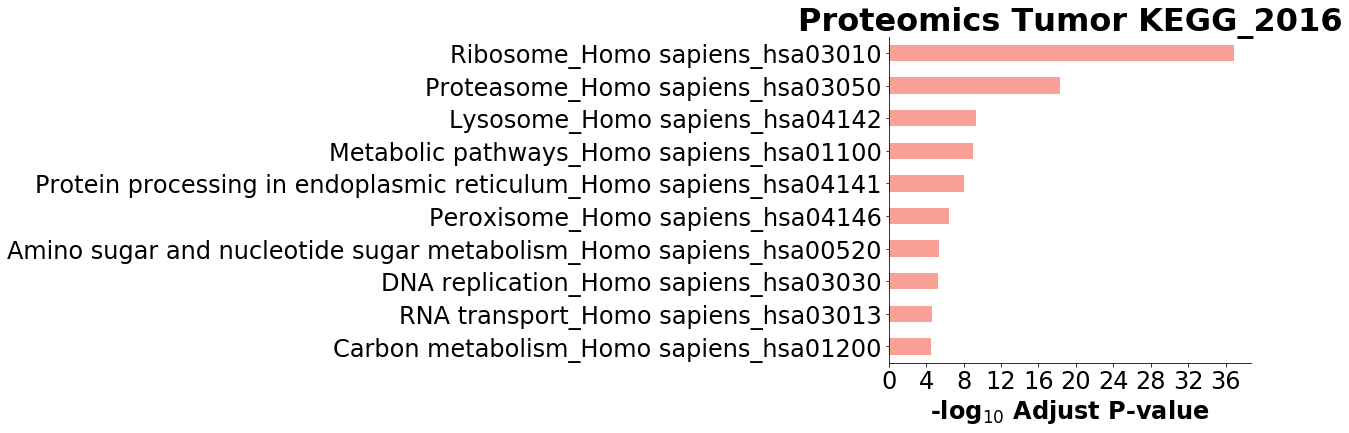

In [33]:
barplot(tumor_enr.res2d,title="Proteomics Tumor KEGG_2016")

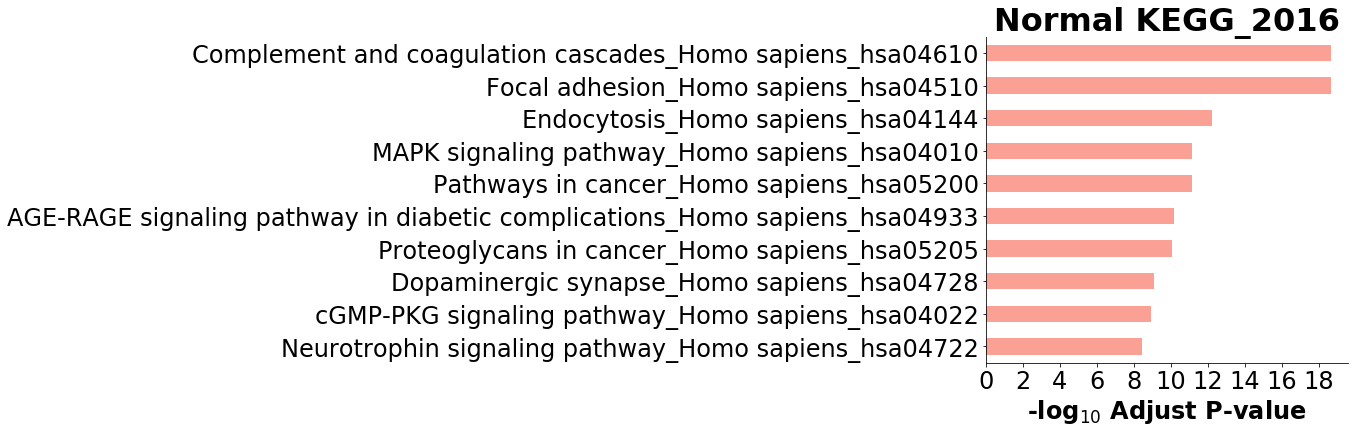

In [34]:
barplot(normal_enr.res2d,title="Normal KEGG_2016")

## Discussion

When comparing these barplots, we can observe the "Tumor" group has one pathway expressed at a very significant adjusted P-value, while the other pathways are expressed at a less significant P-value. The single pathway is the Ribosome pathway, which could be attributed to the "Tumor" genes disrupting ribosome activity, thus intensifying the When compared to the "Normal" group, which has a higher count of high significant P-values, we see that the "Normal" group